In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
from itertools import combinations

In [2]:
POPULATION_SIZE = 1000
INITIAL_SICK = 1
INITIAL_HEALTHY = POPULATION_SIZE - INITIAL_SICK

SICK_COLOR = (1, 0, 0)
HEALTHY_COLOR = (0, 1, 0)
RECOVERED_COLOR = (0.7, 0, 0.7)

In [3]:
class Person:
    x: float
    y: float
    sick: bool
    recovered: bool
    susceptibility: float
    color: tuple[int, int, int]

    def __init__(self, **kwargs):
        self.x = random.random()
        self.y = random.random()
        self.sick = False
        self.recovered = False
        self.color = HEALTHY_COLOR
        self.mobility = random.random()
        self.susceptibility = random.random()
        self.recovered_susceptibility = 0
        for key, value in kwargs.items():
            setattr(self, key, value)

    def get_sick(self):
        """ Become sick, update corresponding fields. """
        self.sick = True
        self.color = SICK_COLOR
        self.susceptibility = 0

    def get_color(self):
        """ Get representation of a person health as a corresponding color. """
        return self.color

    def get_position(self) -> tuple[float, float]:
        """ Return current person location. """
        return self.x, self.y

    def recover(self):
        """ Recover from sickness, update corresponding fields. """
        self.sick = False
        self.recovered = True
        self.color = RECOVERED_COLOR
        self.susceptibility = self.recovered_susceptibility

    def move(self):
        """ Move from previous position to a new one. """
        move_x, move_y = self.get_move_values()
        self.x += move_x
        self.y += move_y
        self.apply_boundary_conditions()

    def apply_boundary_conditions(self):
        """ Check if person did not leave the space of the simulation, if so modifies its position. """
        if self.x > 1:
            self.x -= 1
        if self.x < 0:
            self.x += 1
        if self.y > 1:
            self.y -= 1
        if self.y < 0:
            self.y += 1

    def get_distance_to_travel(self) -> float:
        """ Get distance person will move at the given time step. """
        return random.random() * self.mobility

    @staticmethod
    def get_move_coefficients():
        """ Generate direction in which person will be moved at the given time step. """
        angle = math.radians(random.random() * 360)
        return math.cos(angle), math.sin(angle)

    def get_move_values(self):
        distance_to_move = self.get_distance_to_travel()
        x_coefficient, y_coefficient = self.get_move_coefficients()
        return distance_to_move * x_coefficient, distance_to_move * y_coefficient
    
    def update(self):
        """ Update status related to disease development. """
        pass
    
    def can_get_infected(self):
        """ Returns information if given agent can get infected. """
        return not self.sick
    
    def can_infect(self):
        """ Returns information if given agent can infect others. """
        return self.sick
    
    def get_infected(self):
        if self.susceptibility >= random.random():
            self.get_sick()

In [4]:
class Simulation:
    color = tuple[float, float, float]
    population_time_step = tuple[float, float, color]

    population_size: int
    initial_sick: int
    population: list[Person]
    frames: list[population_time_step]

    fig: plt.Figure
    ax: plt.Axes
    animation: animation

    def __init__(self, population_size: int, initial_sick: int = 1, number_of_frames: int = 30, person_kwargs: dict = {}):
        self.frames = []
        self.initial_sick = initial_sick
        self.population_size = population_size
        self.population = [Person(**person_kwargs) for x in range(population_size)]
        self.contact_radious = 0.2
        self.squared_contanct_radious = self.contact_radious**2
        for idx in range(initial_sick):
            self.population[idx].get_sick()
        self.generate_frames(number_of_frames)
    
    def find_all_interactions(self):
        """ Finds all interactions between 2 agents, ignores order in which agents appear. """
        contacts = set()
        for person_1, person_2 in combinations(self.population, 2):
            distance = self.calcaulate_squared_euclidean_distance(person_1.get_position(), person_2.get_position())
            if distance <= self.squared_contanct_radious:
                contacts.add((person_1, person_2))
        return contacts
    
    @staticmethod
    def find_possible_infections(contacts: set[Person, Person]):
        """ Finds all interactions in which one Person is sick. """
        # TODO introdcution of personal protection for sick (if prob > value yield else pass) saved by individual protection case
        for person_1, person_2 in contacts:
            if person_1.can_get_infected() and person_2.can_infect():
                yield person_1
            elif person_1.can_infect() and person_2.can_get_infected():
                yield person_2
    
    @staticmethod
    def calcaulate_squared_euclidean_distance(first: tuple[float, float], second: tuple[float, float]) -> float:
        return (first[0] - second[0]) **2 + (first[1] - second[1])**2
    
    def generate_frames(self, number_of_frames: int) -> None:
        """ Generates given number of frames of the simulation. """
        self.save_frame(*self.get_population_position())
        for frame in range(number_of_frames):
            self.update_population()
            self.save_frame(*self.get_population_position())    
            
    def update_population(self) -> None:
        """ Updates position and healt status for each person in the population. """
        for person in self.population:
            person.move()
        interactions = self.find_all_interactions()
        possible_infections = set(self.find_possible_infections(interactions))
        for idx, person in enumerate(possible_infections):
            person.get_infected()
    
    def get_population_position(self) -> population_time_step:
        """ Get current x, y coordinates of each person and appropriate color depending on the health status. """
        population_description = ((*person.get_position(), person.get_color()) for person in
                                  self.population)
        return tuple(zip(*population_description))

    def save_frame(self, x: list[float], y: list[float], c: list[color]) -> None:
        """ Adds a single frame representing current state of the simulation to the record. """
        self.frames.append((x, y, c))

    def get_frame(self, frame_index: int = -1) -> population_time_step:
        """ Get selected frame of the simulation. """
        if frame_index not in range(len(self.frames)):
            frame_index = -1
        return self.frames[frame_index]

    def __iter__(self):
        return iter(self.frames)
    

In [5]:
simulation = Simulation(100, number_of_frames=50)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
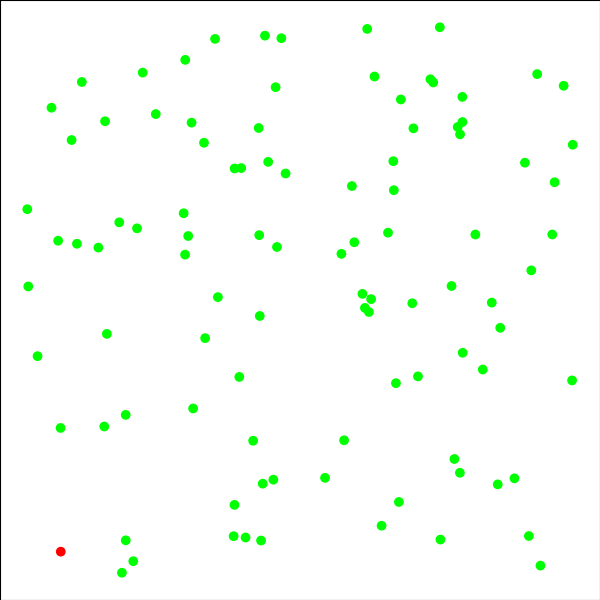

In [6]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, 1])

x, y, c = simulation.frames[0]
scatter = ax.scatter(x=x, y=y, c=c)


def update(frame):
    x, y, c = frame
    scatter.set_offsets(list(zip(x,y)))
    # scatter.set_array(np.array(c)) # Z nieznanego powodu ustawianie koloru tym cudem znika punkty xddd
    

anim = animation.FuncAnimation(fig, update, iter(simulation), interval=200)
plt.show()
    